In [10]:

%load_ext autoreload
%autoreload 2
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:

import numpy as np
import matplotlib.pyplot as plt
from fgbuster import CMB, Dust, Synchrotron, MixingMatrix
from fgbuster.observation_helpers import standardize_instrument, get_observation
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import healpy as hp
import numdifftools as nd
import math as m

In [12]:
instr = np.load('instrument_LB_IMOv1.npy', allow_pickle=True).item()
instr_ = {}
instr_['frequency'] = np.array([instr[f]['freq'] for f in instr.keys()])
instr_['depth_p'] = np.array([instr[f]['P_sens'] for f in instr.keys()])
instr_['fwhm'] = np.array([instr[f]['beam'] for f in instr.keys()])
instr_['depth_i'] = instr_['depth_p']/np.sqrt(2)
instrument = standardize_instrument(instr_)

In [13]:
nside = 64
freq_maps = get_observation(instrument, 'd0s0', noise=False, nside=nside)


In [14]:
components= [CMB(), Dust(50.), Synchrotron(50.)]

In [15]:
A = MixingMatrix(*components)
A_ev = A.evaluator(instrument.frequency)
#invN=np.linalg.inv(np.eye(len(instrument.frequency)))
invN = np.diag((hp.nside2resol(nside, arcmin=True) / instrument.depth_p)**2)

In [16]:
def spectral_likelihood(x):
    invNd = np.einsum('ij,jsp->isp', invN, freq_maps)
    A_maxL =A_ev(x) 
    logL = 0
    AtNd= np.einsum('ji,jsp->isp', A_maxL, invNd)
    AtNA = np.linalg.inv(A_maxL.T.dot(invN).dot(A_maxL))
    logL = logL + np.einsum('isp,ij,jsp->', AtNd, AtNA, AtNd)
    if logL != logL:
        return 0.0
    return -logL

In [17]:
x0 =np.array([1.4,21,-2.5]) 

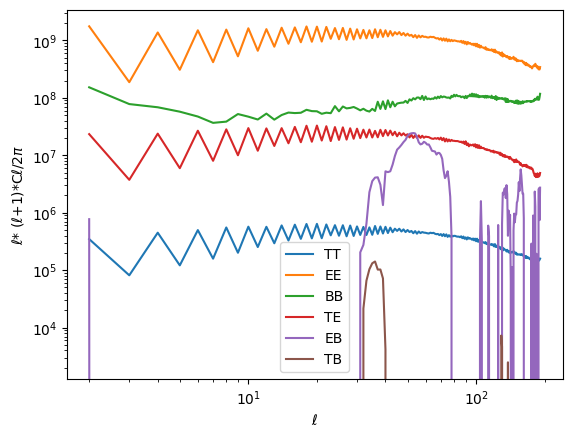

In [19]:
Cl = []
N = 10 
for i in range (N):
    np.random.seed(i)
    noise =np.random.random
    freq_maps = get_observation(instrument, 'd0s0', noise=True, nside=nside)
    def spectral_likelihood(x):
        invNd = np.einsum('ij,jsp->isp', invN, freq_maps)
        A_maxL =A_ev(x) 
        logL = 0
        AtNd= np.einsum('ji,jsp->isp', A_maxL, invNd)
        AtNA = np.linalg.inv(A_maxL.T.dot(invN).dot(A_maxL))
        logL = logL + np.einsum('isp,ij,jsp->', AtNd, AtNA, AtNd)
        if logL != logL:
            return 0.0
        return -logL

    min_= minimize (spectral_likelihood, x0, method='Nelder-Mead')
    # print(min_)
    # print(min_.x)

        
    invNd = np.einsum('ij,jsp->isp', invN, freq_maps)
    A_maxL =A_ev(min_.x) 
    AtNd= np.einsum('ji,jsp->isp', A_maxL, invNd)
    AtNA = np.linalg.inv(A_maxL.T.dot(invN).dot(A_maxL))
    s = AtNA.dot(AtNd)
    G =hp.anafast(s[0])
    G = G.T[2:,:]
    Cl.append(G)

    
ell = np.arange(2,192)

values = []
for i in range(len(G[0,:])):
    y = (ell*(ell+1)*G[:,i])/(2*m.pi)
    values.append(y)


plt.loglog(ell,values[0], label="TT")
plt.loglog(ell,values[1], label="EE")
plt.loglog(ell,values[2], label="BB")
plt.loglog(ell,values[3], label="TE")
plt.loglog(ell,values[4], label="EB")
plt.loglog(ell,values[5], label="TB")


plt.xlabel(r'$\ell$')
plt.ylabel(r'$\ell$* ($\ell$+1)*C$\ell$/2$\pi$')
plt.legend()

    


In [ ]:
def spectral_likelihood(x):
    invNd = np.einsum('ij,jsp->isp', invN, freq_maps)
    A_maxL =A_ev(x) 
    logL = 0
    AtNd= np.einsum('ji,jsp->isp', A_maxL, invNd)
    AtNA = np.linalg.inv(A_maxL.T.dot(invN).dot(A_maxL))
    logL = logL + np.einsum('isp,ij,jsp->', AtNd, AtNA, AtNd)
    if logL != logL:
        return 0.0
    return -logL

In [ ]:
x0 =np.array([1.4,21,-2.5]) 

min_= minimize (spectral_likelihood, x0, method='Nelder-Mead')
print(min_)
print(min_.x)